In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
import wfdb
import re
from math import *
import plotly.express as px

In [2]:
sample_size=5000

# Read source for create a dataset of annotations
Source : https://physionet.org/content/butqdb/1.0.0/

In [3]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
dataannall = pd.DataFrame(columns=header_list)
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name, end="\r")
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannall = pd.concat([dataannall,dataann.assign(record=rcd.split('/')[0])], ignore_index=True)
#Add columns to dataset
dataannall['signal_length']=dataannall['end'] - dataannall['start']
dataannall["sample"]=round(dataannall["signal_length"]/sample_size)
dataannall["class1"].fillna(0, inplace=True)
dataannall["class2"].fillna(0, inplace=True)
dataannall["class3"].fillna(0, inplace=True)
dataannall["class"].fillna(0, inplace=True)
dataannall=dataannall.astype({'class1': 'int32','class2': 'int32','class3': 'int32','class': 'int32'})
dataset = dataannall[dataannall["class"].notnull() & dataannall["start"].notnull() & dataannall["end"].notnull() ]
dataann_nan_class = dataset


In [4]:
dataannall.dtypes

start1           float64
end1             float64
class1             int32
start2           float64
end2             float64
class2             int32
start3            object
end3              object
class3             int32
start            float64
end              float64
class              int32
record            object
signal_length    float64
sample           float64
dtype: object

In [5]:
dataannall.head()

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
0,1.0,198867.0,2,1.0,19525.0,1,1,7047,2,1.0,7047.0,2,100001,7046.0,1.0
1,198868.0,320282.0,1,19526.0,28694.0,2,7048,17209,1,7048.0,17209.0,1,100001,10161.0,2.0
2,320283.0,373109.0,2,28695.0,32739.0,1,17210,28390,2,17210.0,28694.0,2,100001,11484.0,2.0
3,373110.0,2197974.0,1,32740.0,96699.0,2,28391,32653,1,28695.0,32653.0,1,100001,3958.0,1.0
4,2197975.0,2582746.0,2,96700.0,110564.0,1,32654,71061,2,32654.0,112474.0,2,100001,79820.0,16.0


# Try to score the operator notation

In [6]:
#dataannall['class_vote'] = 
class1_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class']) & (dataannall['class'] > 0)])
class12_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class']) & (dataannall['class1'] == dataannall['class2']) & (dataannall['class'] > 0)])
class13_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class']) & (dataannall['class1'] == dataannall['class3']) & (dataannall['class'] > 0)])
class2_ds_f = len(dataannall[(dataannall['class2'] == dataannall['class']) & (dataannall['class'] > 0)])
class23_ds_f = len(dataannall[(dataannall['class2'] == dataannall['class']) & (dataannall['class2'] == dataannall['class3']) & (dataannall['class'] > 0)])
class3_ds_f = len(dataannall[(dataannall['class3'] == dataannall['class']) & (dataannall['class'] > 0)])
class123_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class2']) & (dataannall['class3'] == dataannall['class1']) & (dataannall['class3'] == dataannall['class2']) & (dataannall['class'] > 0)])
class_f = len(dataannall[(dataannall['class'] > 0)])

print(f"Choix opérateur 1 dans choix final \t\t: {class1_ds_f}\t/ {class_f}\t{round(class1_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 2 dans choix final \t\t: {class2_ds_f}\t/ {class_f}\t{round(class2_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 2 dans choix final \t\t: {class3_ds_f}\t/ {class_f}\t{round(class3_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 1 & 2 dans choix final \t\t: {class12_ds_f}\t/ {class_f}\t{round(class12_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 1 & 3 dans choix final \t\t: {class13_ds_f}\t/ {class_f}\t{round(class13_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 2 & 3 dans choix final \t\t: {class23_ds_f}\t/ {class_f}\t{round(class23_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 1 & 2 & 3 dans choix final \t: {class123_ds_f}\t/ {class_f}\t{round(class123_ds_f*100/class_f,2)}%")

Choix opérateur 1 dans choix final 		: 1179	/ 7104	16.6%
Choix opérateur 2 dans choix final 		: 2694	/ 7104	37.92%
Choix opérateur 2 dans choix final 		: 2421	/ 7104	34.08%
Choix opérateur 1 & 2 dans choix final 		: 601	/ 7104	8.46%
Choix opérateur 1 & 3 dans choix final 		: 458	/ 7104	6.45%
Choix opérateur 2 & 3 dans choix final 		: 1072	/ 7104	15.09%
Choix opérateur 1 & 2 & 3 dans choix final 	: 297	/ 7104	4.18%


In [10]:
len(dataannall[dataannall['record'] == '105001'].index)

3495

In [11]:
fig = px.line(dataannall[dataannall['record'] == '105001'], x="end1", y="class1", title='Opérator 1')
fig.show()

In [12]:
fig = px.line(dataannall[dataannall['record'] == '105001'], x="end2", y="class2", title='Opérator 2')
fig.show()

In [13]:
fig = px.line(dataannall[dataannall['record'] == '105001'], x="end3", y="class3", title='Opérator 3')
fig.show()

In [14]:
df = dataannall[(dataannall['record'] == '105001')]
df.count()
df.max()

start1           139120080.0
end1             139147000.0
class1                   3.0
start2           139146833.0
end2             139147000.0
class2                   3.0
start3           139116480.0
end3             139147000.0
class3                   3.0
start            139120080.0
end              139147000.0
class                    3.0
record              105001.0
signal_length     47323499.0
sample                9465.0
dtype: float64

In [15]:
dataannall.groupby('record').max()

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length,sample
record,,,,,,,,,,,,,,
100001,86827128.0,87087000.0,3,84055553.0,87087000.0,3,86588416.0,87087000.0,3,86827128.0,87087000.0,3,3704742.0,741.0
100002,58800001.0,86762000.0,2,58800001.0,86762000.0,2,58800001.0,86762000.0,2,58800001.0,86762000.0,2,28799999.0,5760.0
103001,58800001.0,87125000.0,3,58800001.0,87125000.0,3,58800001.0,87125000.0,3,58800001.0,87125000.0,3,28799999.0,5760.0
103002,58800001.0,86482000.0,3,58800001.0,86482000.0,2,58800001.0,86482000.0,2,58800001.0,86482000.0,2,28799999.0,5760.0
103003,58800001.0,86420000.0,3,58800001.0,86420000.0,2,58800001.0,86420000.0,2,58800001.0,86420000.0,2,28799999.0,5760.0
104001,58800001.0,87178000.0,3,58800001.0,87178000.0,3,58800001.0,87178000.0,2,58800001.0,87178000.0,2,28799999.0,5760.0
105001,139120080.0,139147000.0,3,139146833.0,139147000.0,3,139116480.0,139147000.0,3,139120080.0,139147000.0,3,47323499.0,9465.0
111001,90622552.0,90645000.0,3,89873168.0,90645000.0,3,90622472.0,90645000.0,3,90622552.0,90645000.0,3,3179614.0,636.0
113001,58800001.0,91148000.0,3,58800001.0,91148000.0,3,58800001.0,91148000.0,3,58800001.0,91148000.0,3,32347999.0,6470.0


In [16]:
139147000/1000/3600/24

1.6104976851851853

In [17]:
import plotly.graph_objects as go
df = dataannall[(dataannall['record'] == '105001') & (dataannall['start'] > 20000000)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['end1'],
                         y=df['class1'], name="Ope1",
                    line_shape='hv'))
fig.add_trace(go.Scatter(x=df['end2'],
                         y=df['class2'], name="Ope2",
                    line_shape='hv'))
fig.add_trace(go.Scatter(x=df['end3'],
                         y=df['class3'], name="Op3",
                    line_shape='hv'))
fig.add_trace(go.Scatter(x=df['end'],
                         y=df['class'], name="Quorum",
                    line_shape='hv'))
"""fig.add_trace(go.Scatter(x=x, y=y + 15, name="hvh",
                    line_shape='hvh'))
fig.add_trace(go.Scatter(x=x, y=y + 20, name="vh",
                    line_shape='vh'))
fig.add_trace(go.Scatter(x=x, y=y + 25, name="hv",
                    line_shape='hv'))

fig.update_traces(hoverinfo='text+name', mode='lines+markers')
fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16))
"""
fig.show()

# Check if it's continous notations

In [19]:
for i in dataannall[dataannall['record'] == '105001'].index:
    ope1=f"{dataannall['end1'][i]} : {dataannall['end1'][i]-dataannall['start1'][i+1]+1}"
    ope2=f"{dataannall['end2'][i]} : {dataannall['end2'][i]-dataannall['start2'][i+1]+1}"
    ope3=f"{dataannall['end3'][i]} : {dataannall['end3'][i]-dataannall['start3'][i+1]+1}"
    final=f"{dataannall['end'][i]} : {dataannall['end'][i]-dataannall['start'][i+1]+1}"
    print(f"{ope1} - {ope2} - {ope3} - {final} -")

47323379.0 : 0.0 - 47323871.0 : 0.0 - 47323500 : 0 - 47323500.0 : 0.0 -
47388207.0 : 0.0 - 47329547.0 : 0.0 - 47323539 : 0 - 47326788.0 : 0.0 -
47404719.0 : 0.0 - 47333899.0 : 0.0 - 47326788 : 0 - 47329547.0 : 0.0 -
47449035.0 : 0.0 - 47370615.0 : 0.0 - 47329715 : 0 - 47333904.0 : 0.0 -
47492819.0 : 0.0 - 47377747.0 : 0.0 - 47333904 : 0 - 47370615.0 : 0.0 -
47530727.0 : 0.0 - 47405071.0 : 0.0 - 47370655 : 0 - 47377747.0 : 0.0 -
47552003.0 : 0.0 - 47410939.0 : 0.0 - 47374840 : 0 - 47405035.0 : 0.0 -
47555487.0 : 0.0 - 47511815.0 : 0.0 - 47405035 : 0 - 47420808.0 : 0.0 -
47569223.0 : 0.0 - 47519135.0 : 0.0 - 47420808 : 0 - 47422887.0 : 0.0 -
47601543.0 : 0.0 - 47813343.0 : 0.0 - 47422887 : 0 - 47424808.0 : 0.0 -
47630779.0 : 0.0 - 47817660.0 : 0.0 - 47424808 : 0 - 47427007.0 : 0.0 -
47642383.0 : 0.0 - 47822891.0 : 0.0 - 47427007 : 0 - 47430768.0 : 0.0 -
47661719.0 : 0.0 - 47829044.0 : 0.0 - 47430768 : 0 - 47446195.0 : 0.0 -
47684023.0 : 0.0 - 47833451.0 : 0.0 - 47446195 : 0 - 47448152.0 

nan : nan - 124066968.0 : 0.0 - 70866671 : 0 - 92516208.0 : 0.0 -
nan : nan - 124109303.0 : 0.0 - 70867680 : 0 - 92536359.0 : 0.0 -
nan : nan - 124132440.0 : 0.0 - 70882415 : 0 - 92551272.0 : 0.0 -
nan : nan - 124141767.0 : 0.0 - 70887048 : 0 - 92643495.0 : 0.0 -
nan : nan - 124189488.0 : 0.0 - 70888959 : 0 - 92649336.0 : 0.0 -
nan : nan - 124200863.0 : 0.0 - 70892240 : 0 - 92656631.0 : 0.0 -
nan : nan - 124217944.0 : 0.0 - 70893431 : 0 - 92663152.0 : 0.0 -
nan : nan - 124226271.0 : 0.0 - 70895920 : 0 - 92668399.0 : 0.0 -
nan : nan - 124237848.0 : 0.0 - 70899703 : 0 - 92715920.0 : 0.0 -
nan : nan - 124241407.0 : 0.0 - 70903928 : 0 - 93032759.0 : 0.0 -
nan : nan - 124248040.0 : 0.0 - 70915167 : 0 - 93410400.0 : 0.0 -
nan : nan - 124269047.0 : 0.0 - 70917936 : 0 - 93421983.0 : 0.0 -
nan : nan - 124961352.0 : 0.0 - 70920879 : 0 - 93427688.0 : 0.0 -
nan : nan - 125034239.0 : 0.0 - 70923320 : 0 - 93433671.0 : 0.0 -
nan : nan - 125055008.0 : 0.0 - 70926431 : 0 - 93479024.0 : 0.0 -
nan : nan 

nan : nan - nan : nan - 80877832 : 0 - nan : nan -
nan : nan - nan : nan - 80882791 : 0 - nan : nan -
nan : nan - nan : nan - 80885464 : 0 - nan : nan -
nan : nan - nan : nan - 80888879 : 0 - nan : nan -
nan : nan - nan : nan - 80892464 : 0 - nan : nan -
nan : nan - nan : nan - 80901679 : 0 - nan : nan -
nan : nan - nan : nan - 80905896 : 0 - nan : nan -
nan : nan - nan : nan - 80911359 : 0 - nan : nan -
nan : nan - nan : nan - 80915680 : 0 - nan : nan -
nan : nan - nan : nan - 80918063 : 0 - nan : nan -
nan : nan - nan : nan - 80924496 : 0 - nan : nan -
nan : nan - nan : nan - 80927191 : 0 - nan : nan -
nan : nan - nan : nan - 80931592 : 0 - nan : nan -
nan : nan - nan : nan - 80933655 : 0 - nan : nan -
nan : nan - nan : nan - 80936264 : 0 - nan : nan -
nan : nan - nan : nan - 80937727 : 0 - nan : nan -
nan : nan - nan : nan - 80940680 : 0 - nan : nan -
nan : nan - nan : nan - 80941743 : 0 - nan : nan -
nan : nan - nan : nan - 80943120 : 0 - nan : nan -
nan : nan - nan : nan - 8094974

nan : nan - nan : nan - 93449775 : 0 - nan : nan -
nan : nan - nan : nan - 93455560 : 0 - nan : nan -
nan : nan - nan : nan - 93494423 : 0 - nan : nan -
nan : nan - nan : nan - 93495152 : 0 - nan : nan -
nan : nan - nan : nan - 93526183 : 0 - nan : nan -
nan : nan - nan : nan - 93538128 : 0 - nan : nan -
nan : nan - nan : nan - 93574135 : 0 - nan : nan -
nan : nan - nan : nan - 93634856 : 0 - nan : nan -
nan : nan - nan : nan - 93650839 : 0 - nan : nan -
nan : nan - nan : nan - 93651592 : 0 - nan : nan -
nan : nan - nan : nan - 96944287 : 0 - nan : nan -
nan : nan - nan : nan - 96952456 : 0 - nan : nan -
nan : nan - nan : nan - 97055735 : 0 - nan : nan -
nan : nan - nan : nan - 97063528 : 0 - nan : nan -
nan : nan - nan : nan - 97096943 : 0 - nan : nan -
nan : nan - nan : nan - 97100288 : 0 - nan : nan -
nan : nan - nan : nan - 97615703 : 0 - nan : nan -
nan : nan - nan : nan - 97616488 : 0 - nan : nan -
nan : nan - nan : nan - 97622711 : 0 - nan : nan -
nan : nan - nan : nan - 9762476

nan : nan - nan : nan - 132073775 : 0 - nan : nan -
nan : nan - nan : nan - 132085392 : 0 - nan : nan -
nan : nan - nan : nan - 132086895 : 0 - nan : nan -
nan : nan - nan : nan - 132096528 : 0 - nan : nan -
nan : nan - nan : nan - 132121015 : 0 - nan : nan -
nan : nan - nan : nan - 132139856 : 0 - nan : nan -
nan : nan - nan : nan - 132146663 : 0 - nan : nan -
nan : nan - nan : nan - 132174096 : 0 - nan : nan -
nan : nan - nan : nan - 132228687 : 0 - nan : nan -
nan : nan - nan : nan - 132264328 : 0 - nan : nan -
nan : nan - nan : nan - 132291647 : 0 - nan : nan -
nan : nan - nan : nan - 132292792 : 0 - nan : nan -
nan : nan - nan : nan - 132298159 : 0 - nan : nan -
nan : nan - nan : nan - 132304128 : 0 - nan : nan -
nan : nan - nan : nan - 132333039 : 0 - nan : nan -
nan : nan - nan : nan - 132339760 : 0 - nan : nan -
nan : nan - nan : nan - 132360207 : 0 - nan : nan -
nan : nan - nan : nan - 132368848 : 0 - nan : nan -
nan : nan - nan : nan - 132402791 : 0 - nan : nan -
nan : nan - 

In [167]:
dataset.describe()

,start1,end1,class1,start2,end2,class2,start,end,class,signal_length,sample
count,2.076000e+03,2.076000e+03,2076.000000,4.305000e+03,4.305000e+03,4305.000000,7.154000e+03,7.154000e+03,7154.000000,7.154000e+03,7154.000000
mean,5.735894e+07,5.817328e+07,1.748073,5.950179e+07,5.987307e+07,1.572590,5.601431e+07,5.625521e+07,1.604417,2.409030e+05,48.144255
std,3.225315e+07,3.202552e+07,0.731805,3.072217e+07,3.057915e+07,0.603114,2.802337e+07,2.796447e+07,0.609641,2.530322e+06,506.072488
min,1.000000e+00,1.988670e+05,0.000000,1.000000e+00,1.952500e+04,0.000000,1.000000e+00,7.047000e+03,0.000000,3.020000e+02,0.000000
25%,2.961164e+07,2.970962e+07,1.000000,3.180192e+07,3.216237e+07,1.000000,3.405290e+07,3.411941e+07,1.000000,2.264250e+03,0.000000
50%,5.676074e+07,5.760000e+07,2.000000,5.791413e+07,5.792801e+07,2.000000,5.507225e+07,5.570303e+07,2.000000,5.853000e+03,1.000000
75%,7.522529e+07,7.664065e+07,2.000000,7.722608e+07,7.766738e+07,2.000000,6.858724e+07,6.945778e+07,2.000000,1.982150e+04,4.000000
max,1.391201e+08,1.391470e+08,3.000000,1.391468e+08,1.391470e+08,3.000000,1.391201e+08,1.391470e+08,3.000000,7.464800e+07,14930.000000


In [168]:
dataset.sort_values(by=['signal_length']).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
2164,29830121.0,29843829.0,2.0,29833497.0,29842799.0,2.0,29041071,29041373,2,29041071.0,29041373.0,2.0,104001,302.0,0.0
6902,NaN,NaN,NaN,NaN,NaN,NaN,22772239,22806837,1,42187296.0,42187599.0,2.0,111001,303.0,0.0
14215,57653762.0,57664665.0,1.0,29052794.0,29058124.0,1.0,28815944,28816279,1,28871845.0,28872149.0,1.0,121001,304.0,0.0
1961,29896114.0,29909814.0,1.0,29430978.0,29432026.0,2.0,29201971,29203041,2,29367658.0,29367979.0,2.0,103003,321.0,0.0
14982,NaN,NaN,NaN,65811759.0,65824014.0,3.0,58413007,58414129,1,65500416.0,65500737.0,2.0,124001,321.0,0.0
15543,57711177.0,57779132.0,1.0,29622202.0,29624040.0,1.0,28902711,29014385,1,29637312.0,29637634.0,1.0,126001,322.0,0.0
2087,NaN,NaN,NaN,NaN,NaN,NaN,29712177,29713943,2,29974330.0,29974654.0,2.0,103003,324.0,0.0
1347,NaN,NaN,NaN,29422321.0,29423807.0,2.0,2.95904e+07,2.95909e+07,2,29583767.0,29584095.0,2.0,100002,328.0,0.0
15582,NaN,NaN,NaN,57917191.0,57917810.0,2.0,57655491,57655835,2,58410626.0,58410956.0,2.0,126001,330.0,0.0
14943,NaN,NaN,NaN,65570247.0,65579982.0,1.0,58189527,58190516,2,65289466.0,65289798.0,2.0,124001,332.0,0.0


In [42]:
dataannall.sort_values(by=['sample'],ascending=False).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
14558,NaN,NaN,NaN,NaN,NaN,NaN,29981332,29991362,2,58800001.0,133448000.0,0.0,123001,74647999.0,7465.0
14419,NaN,NaN,NaN,NaN,NaN,NaN,58497423,58499060,1,58800001.0,122798000.0,0.0,122001,63997999.0,6400.0
2299,1.0,47323379.0,3.0,1.0,47323871.0,3.0,1,47323500,3,1.0,47323500.0,3.0,105001,47323499.0,4732.0
15596,NaN,NaN,NaN,58407654.0,58408005.0,2.0,57821475,57824016,2,58800001.0,92361000.0,0.0,126001,33560999.0,3356.0
13716,57600001.0,58800000.0,1.0,29389929.0,29392545.0,2.0,28903735,28905450,2,58800001.0,91651000.0,0.0,114001,32850999.0,3285.0
14375,NaN,NaN,NaN,NaN,NaN,NaN,58662590,58670947,1,58800001.0,91233000.0,0.0,121001,32432999.0,3243.0
13539,NaN,NaN,NaN,NaN,NaN,NaN,36544236,36546336,1,58800001.0,91148000.0,0.0,113001,32347999.0,3235.0
14073,NaN,NaN,NaN,58800001.0,89091000.0,0.0,58102368,58112099,2,58800001.0,89091000.0,0.0,118001,30290999.0,3029.0
13892,NaN,NaN,NaN,NaN,NaN,NaN,58398360,58401557,1,58800001.0,87934000.0,0.0,115001,29133999.0,2913.0
13949,1.0,28800000.0,0.0,1.0,28800000.0,0.0,1,28800000,0,1.0,28800000.0,0.0,118001,28799999.0,2880.0


# Check class and repartition

In [22]:
dataset.record.unique()

array(['100001', '100002', '103001', '103002', '103003', '104001',
       '105001', '111001', '113001', '114001', '115001', '118001',
       '121001', '122001', '123001', '124001', '125001', '126001'],
      dtype=object)

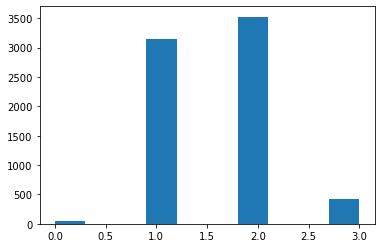

In [23]:
plt.hist(dataset['class'], bins=10);
plt.show()

/Users/david/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Users/david/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



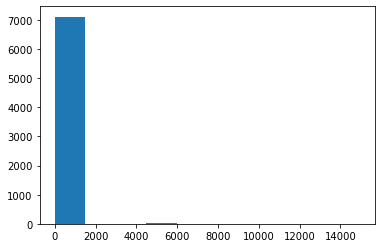

In [24]:
plt.hist(dataannall['sample'], bins=10);
plt.show()

In [25]:
dataannall.dtypes

start1           float64
end1             float64
class1             int32
start2           float64
end2             float64
class2             int32
start3            object
end3              object
class3             int32
start            float64
end              float64
class              int32
record            object
signal_length    float64
sample           float64
dtype: object

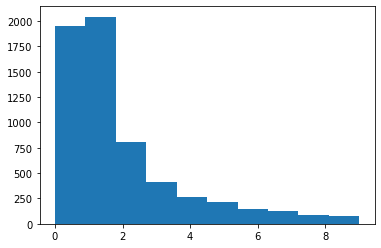

In [26]:
plt.hist(dataannall[dataannall['sample'] < 10]['sample'], bins=10);
plt.show()

In [27]:
pie_chart_data = dataset[dataset['record'] == '100001'].groupby('class')['sample'].sum()
pie_chart_data.shape

(3,)

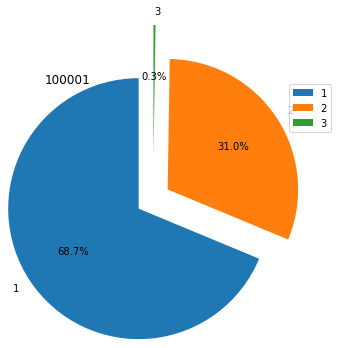

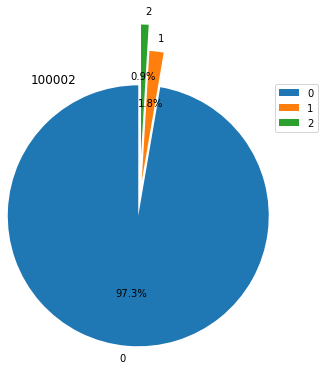

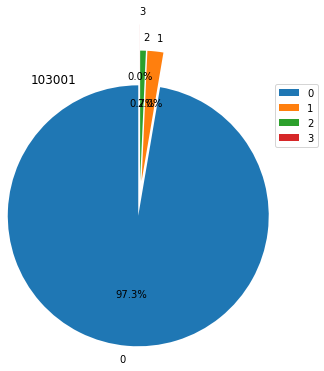

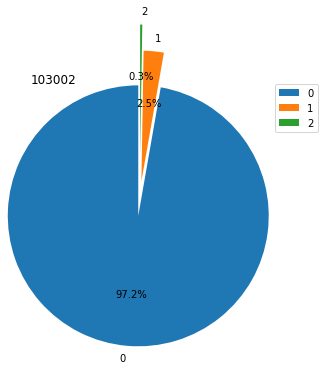

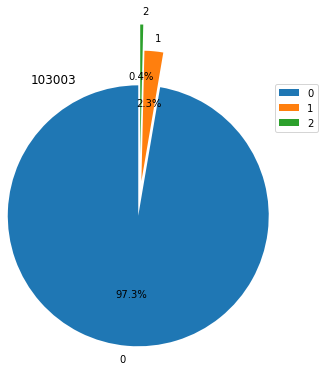

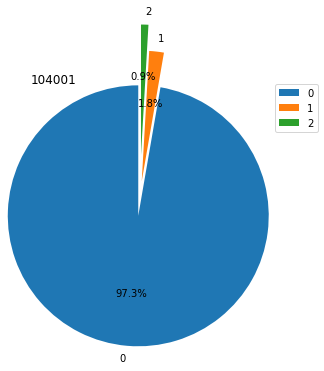

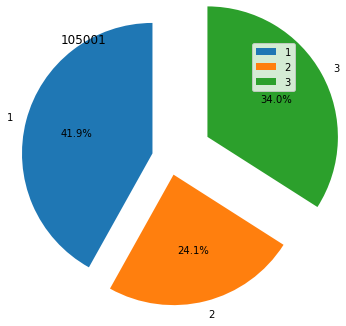

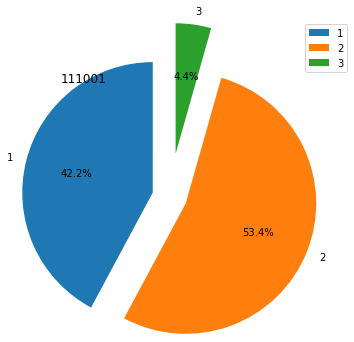

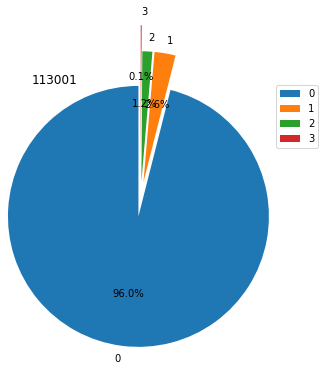

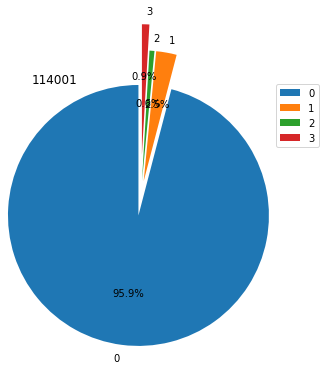

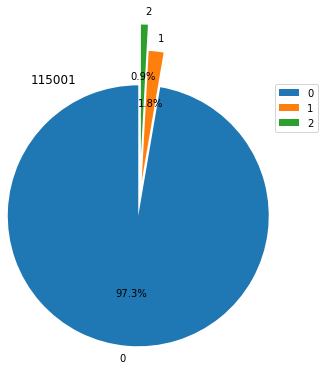

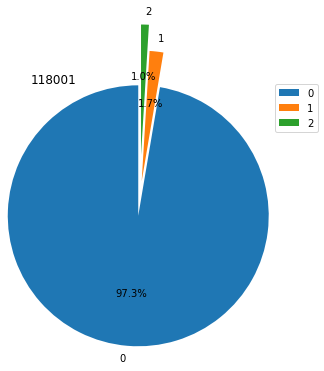

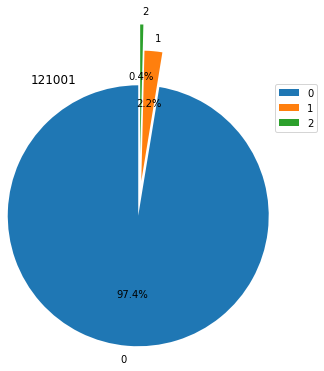

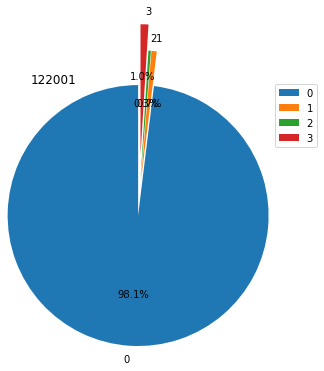

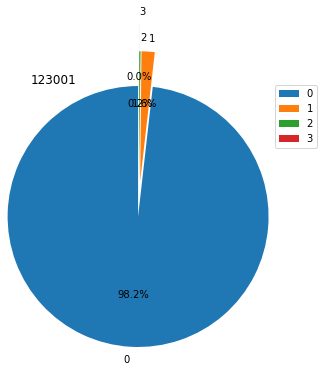

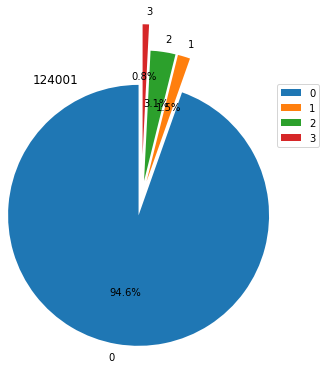

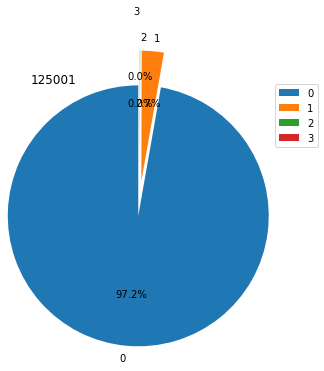

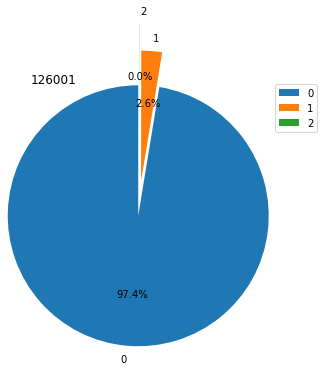

In [28]:
"""dataset['class_name'] = dataset['class'].apply(lambda x:
                                                     "Class 1: All significant waveforms" if int(x)==1 
                                                     else "Class 2: The noise level is increased" if int(x)==2
                                                     else "Class 3: The signal is unsuitable for any analysis. " if int(x)==3 
                                                     else "Class 0: The quality was not annotated ")
"""
for patient in dataannall.record.unique():
    pie_chart_data = dataset[dataset['record'] == patient].groupby('class')['sample'].sum()
    if pie_chart_data.shape[0] == 3:
        explode = (0.2,0.2,0.5)
    else:
        explode = (0.2,0.2,0.2,0.5)
    
    plt.figure()
    plt.pie(pie_chart_data.values, labels=pie_chart_data.index,  
           autopct='%1.1f%%',
           shadow=False, 
           startangle=90,
           explode=explode,
           radius=1.5
           )
    plt.title(patient, fontdict=None,loc='left')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

# Read source and create 2 lists > Bad way to slow
ecg_data : data
ecg_labels : labels quality class (1, 2 or 3; 0 means the quality was not annotated in this segment) 
Source : https://physionet.org/content/butqdb/1.0.0/

In [34]:
#For cut sample into n sample with cut_size
def ecgreshape(ecg_array,cut_size):
    ecg_size_multi = ceil(ecg_array.shape[0]/cut_size)
    ecg_result = np.zeros(ecg_size_multi*cut_size)
    ecg_result[:ecg_array.shape[0]] = ecg_array
    print(f"Array size {ecg_array.shape[0]} cut by {cut_size} done {ecg_size_multi}", end="\r")
    ecg_result = np.reshape(ecg_result, (ecg_size_multi,cut_size))
    return ecg_result


In [35]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['105001/105001_ECG']
ecg_data=[np.zeros(sample_size)]
ecg_labels=[]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        for i in dataann_nan_class.index:
            record = wfdb.rdrecord(record_name, sampfrom=int(dataann_nan_class.start[i]), sampto=int(dataann_nan_class.end[i]))
            ecg_data = np.concatenate((ecg_data,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_labels.append(int(dataann_nan_class["class"][i]))
            if i == 50: #for test not for production
                break

../aura-data/105001/105001_ECG


# Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


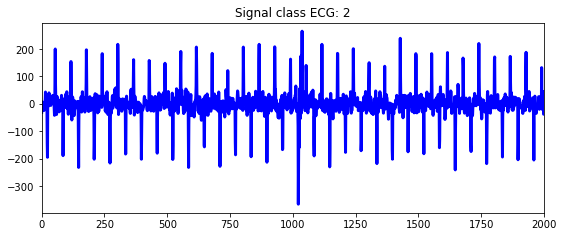

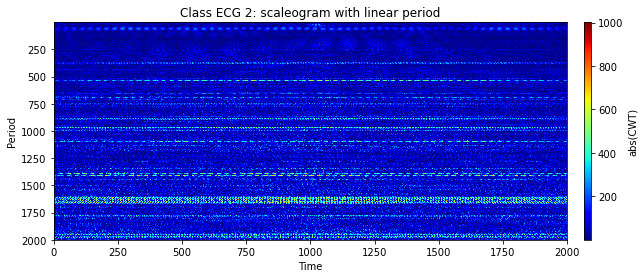

In [39]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 2
signal_length = 2000
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_data[nn]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_data[nn], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {ecg_labels[nn]}")

# the scaleogram
dav = scg.cws(ecg_data[nn][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {ecg_labels[nn]}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

# ICI c'est le bac à sable

In [135]:
#Test to validate ecgreshape
result = np.zeros(9)
result[:a.shape[0]] = a
np.reshape(result, (3, 3))
#print(ecgreshape(a,5))
b=[[1,2,2]]
b.append([3,8,6])
b=[np.zeros(2)]
print(ecgreshape(a,2))
print(b[0].shape,ecgreshape(a,2).shape)
np.concatenate((b,ecgreshape(a,2)), axis=0)

[[1. 2.]
 [3. 4.]
 [5. 6.]
 [7. 0.]]
(2,) (4, 2)


array([[0., 0.],
       [1., 2.],
       [3., 4.],
       [5., 6.],
       [7., 0.]])

In [56]:
#Essai pour boucle while
sample_start=0
sample_end=sample_size
ex=15789
while sample_end < ex:
    print(sample_start,sample_end,sample_size)
    sample_start=sample_end
    sample_end+=sample_size

0 5000 5000
5000 10000 5000
10000 15000 5000


In [182]:
a = np.array([1,2,3,4,5,6,7,8,9,10])

In [223]:
b = a[::4] 

In [224]:
b

array([1, 5, 9])

In [186]:
c = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])

In [221]:
c

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [222]:
d = c[::4]

In [199]:
d

array([[ 1,  2,  3,  4],
       [ 9, 10, 11, 12]])

In [213]:
d=[]
for arr in c:
    d.append(arr[::2])

In [214]:
d

[array([1, 3]), array([5, 7]), array([ 9, 11])]

In [220]:
from scipy.interpolate import interp1d
xp = np.arange(1, len(c), 2)
xp

array([1])

# Work on 105001_ANN for  notations analysis

In [6]:
record = wfdb.rdrecord('100001_ECG', pn_dir='butqdb/100001/', sampfrom=0, sampto=20000)

In [320]:
df = pd.read_csv('https://physionet.org/files/butqdb/1.0.0/105001/105001_ANN.csv', names=header_list)

In [321]:
df.head()

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class
0,1.0,47323379.0,3.0,1.0,47323871.0,3.0,1,47323500,3,1.0,47323500.0,3.0
1,47323380.0,47388207.0,2.0,47323872.0,47329547.0,1.0,47323501,47323539,1,47323501.0,47326788.0,2.0
2,47388208.0,47404719.0,1.0,47329548.0,47333899.0,2.0,47323540,47326788,2,47326789.0,47329547.0,1.0
3,47404720.0,47449035.0,2.0,47333900.0,47370615.0,1.0,47326789,47329715,1,47329548.0,47333904.0,2.0
4,47449036.0,47492819.0,1.0,47370616.0,47377747.0,2.0,47329716,47333904,2,47333905.0,47370615.0,1.0


In [322]:
len(df)

3495

In [323]:
finaltime = np.concatenate((df.start1,df.end1,df.start2,df.end2,df.start3,df.end3,df.start,df.end), axis=0)
finalclass = np.concatenate((df.class1,df.class1,df.class2,df.class2,df.class3,df.class3,df['class'],df['class']), axis=0)
finalope = np.concatenate((np.full(len(df)*2,1),np.full(len(df)*2,2),np.full(len(df)*2,3),np.full(len(df)*2,4)),axis=0)

In [324]:
finalope.shape

(27960,)

In [325]:
columns = ['time','class','operator']
data = np.stack((finaltime, finalclass,finalope), axis=1)
dfclass = pd.DataFrame(data=data, columns=columns)
dfclass["class"].fillna(0, inplace=True)
dfclass.dropna(inplace=True)
dfclass=dfclass.astype({'time': 'int32','class': 'int32','operator': 'int32'})
dfclass.head()

,time,class,operator
0,1,3,1
1,47323380,2,1
2,47388208,1,1
3,47404720,2,1
4,47449036,1,1


In [326]:
#dataannall["class1"].fillna(0, inplace=True)
dfclass.isna().sum()

time        0
class       0
operator    0
dtype: int64

In [327]:
len(dfclass)

13128

In [328]:
dfclass=dfclass.sort_values('time')
dfclass.head(20)

,time,class,operator
0,1,3,1
6990,1,3,2
13980,1,3,3
20970,1,3,4
3495,47323379,3,1
1,47323380,2,1
17475,47323500,3,3
24465,47323500,3,4
13981,47323501,1,3
20971,47323501,2,4


In [329]:
arrmissing=[]
timref = 1
ope1 = -1
ope2 = -1
ope3 = -1
ope4 = -1
for i in dfclass.index:
    if timref != dfclass.time[i]:
        if ope1 < 0:
            arrmissing.append([timref,ope1last,1])
            #print(f"missing1 {timref} alors j'affecte {ope1last}")
        else:
            ope1last = ope1
        if ope2 < 0:
            arrmissing.append([timref,ope2last,2])
            #print(f"missing2 {timref} alors j'affecte {ope2last}")
        else:
            ope2last = ope2
        if ope3 < 0:
            arrmissing.append([timref,ope3last,3])
            #print(f"missing3 {timref} alors j'affecte {ope3last}")
        else:
            ope3last = ope3
        if ope4 < 0:
            arrmissing.append([timref,ope4last,4])
            #print(f"missing4 {timref} alors j'affecte {ope4last}")
        else:
            ope4last = ope4     
        ope1 = -1
        ope2 = -1
        ope3 = -1
        ope4 = -1
    if dfclass.operator[i] == 1:
        ope1 = dfclass['class'][i]
    if dfclass.operator[i] == 2:
        ope2 = dfclass['class'][i]
    if dfclass.operator[i] == 3:
        ope3 = dfclass['class'][i]
    if dfclass.operator[i] == 4:
        ope4 = dfclass['class'][i]        
    timref = dfclass.time[i]
    

    

In [341]:
dfclassmissing = pd.DataFrame(data=arrmissing, columns=columns)
dffinal = pd.concat([dfclassmissing,dfclass])
dffinal = dffinal.sort_values('time').reset_index(drop=True)

In [342]:
dffinal.groupby(['time']).count().min()

class       4
operator    4
dtype: int64

In [343]:
len(dffinal[(dffinal['operator'] == 1)])
dffinal[(dffinal['operator'] == 1)].sort_values('time')

,time,class,operator
3,1,3,1
4,47323379,3,1
10,47323380,2,1
14,47323500,2,1
19,47323501,2,1
...,...,...,...
41577,139120079,1,1
41578,139120080,3,1
41582,139146832,3,1
41589,139146833,3,1


In [344]:
len(dffinal[(dffinal['operator'] == 2)])
dffinal[(dffinal['operator'] == 2)].groupby(['time']).count().sort_values('class')

,class,operator
time,,
1,1,1
104919040,1,1
104919041,1,1
104919775,1,1
104919776,1,1
...,...,...
77451144,1,1
77451145,1,1
77477720,1,1


In [347]:
dffinal.drop([17540,28176], inplace=True)
dffinal[((dffinal['time'] == 111664608) | (dffinal['time'] == 81233304)) & (dffinal['operator'] == 2)]
#len(dffinal[(dffinal['operator'] == 2)])

,time,class,operator
17536,81233304,2,2
28177,111664608,2,2


In [348]:
len(dffinal[(dffinal['operator'] == 3)])

10398

In [349]:
len(dffinal[(dffinal['operator'] == 4)])

10398

In [350]:
data = np.stack(([dffinal[(dffinal['operator'] == 1)]['time'].values,
           dffinal[(dffinal['operator'] == 1)]['class'].values,
           dffinal[(dffinal['operator'] == 2)]['class'].values,
           dffinal[(dffinal['operator'] == 3)]['class'].values,
           dffinal[(dffinal['operator'] == 4)]['class'].values]), axis=1)
#data = np.stack((finaltime, finalclass,finalope), axis=1)



In [351]:
dataannall = pd.DataFrame(data=data, columns=['time','class1','class2','class3','class'])

In [353]:
#dataannall['class_vote'] = 
class1_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class']) & (dataannall['class'] > 0)])
class12_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class']) & (dataannall['class1'] == dataannall['class2']) & (dataannall['class'] > 0)])
class13_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class']) & (dataannall['class1'] == dataannall['class3']) & (dataannall['class'] > 0)])
class2_ds_f = len(dataannall[(dataannall['class2'] == dataannall['class']) & (dataannall['class'] > 0)])
class23_ds_f = len(dataannall[(dataannall['class2'] == dataannall['class']) & (dataannall['class2'] == dataannall['class3']) & (dataannall['class'] > 0)])
class3_ds_f = len(dataannall[(dataannall['class3'] == dataannall['class']) & (dataannall['class'] > 0)])
class123_ds_f = len(dataannall[(dataannall['class1'] == dataannall['class2']) & (dataannall['class3'] == dataannall['class1']) & (dataannall['class3'] == dataannall['class2']) & (dataannall['class'] > 0)])
class_f = len(dataannall[(dataannall['class'] > 0)])

print(f"Choix opérateur 1 dans choix final \t\t: {class1_ds_f}\t/ {class_f}\t{round(class1_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 2 dans choix final \t\t: {class2_ds_f}\t/ {class_f}\t{round(class2_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 3 dans choix final \t\t: {class3_ds_f}\t/ {class_f}\t{round(class3_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 1 & 2 dans choix final \t\t: {class12_ds_f}\t/ {class_f}\t{round(class12_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 1 & 3 dans choix final \t\t: {class13_ds_f}\t/ {class_f}\t{round(class13_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 2 & 3 dans choix final \t\t: {class23_ds_f}\t/ {class_f}\t{round(class23_ds_f*100/class_f,2)}%")
print(f"Choix opérateur 1 & 2 & 3 dans choix final \t: {class123_ds_f}\t/ {class_f}\t{round(class123_ds_f*100/class_f,2)}%")

Choix opérateur 1 dans choix final 		: 8929	/ 10398	85.87%
Choix opérateur 2 dans choix final 		: 9298	/ 10398	89.42%
Choix opérateur 3 dans choix final 		: 6408	/ 10398	61.63%
Choix opérateur 1 & 2 dans choix final 		: 7830	/ 10398	75.3%
Choix opérateur 1 & 3 dans choix final 		: 4939	/ 10398	47.5%
Choix opérateur 2 & 3 dans choix final 		: 5316	/ 10398	51.13%
Choix opérateur 1 & 2 & 3 dans choix final 	: 3848	/ 10398	37.01%


In [245]:
df = dataannall.sort_values('time')
df

,time,class1,class2,class3,class
3110,1,2,1,2,2
0,7047,2,1,2,2
1,7048,2,1,2,2
2,17209,2,1,1,2
3,17210,2,1,1,2
...,...,...,...,...,...
3507,86757975,2,1,2,2
3508,86757976,1,2,1,1
3509,86827127,1,2,1,1
3510,86827128,2,1,2,2


In [247]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'],
                         y=df['class1'], name="Ope1",
                    line_shape='hv'))
fig.add_trace(go.Scatter(x=df['time'],
                         y=df['class2'], name="Ope2",
                    line_shape='hv'))
fig.add_trace(go.Scatter(x=df['time'],
                         y=df['class3'], name="Op3",
                    line_shape='hv'))
fig.add_trace(go.Scatter(x=df['time'],
                         y=df['class'], name="Quorum",
                    line_shape='hv'))
fig.show()